# GHG emissions of EU27 countries in a given year (in a treemap)

In [1]:
import os
import sys

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../"))


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import eurostat
import squarify

from data_analysis.eurostat_geo import *
from data_analysis.illustrator_strings import *
from data_analysis.texts_emissions import *
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_code
from data_analysis.eurostat_population_utils import get_eurostat_population_data


## Parameters

In [3]:
YEAR = 2021

# Don't convert svg texts to curves.
plt.rcParams['svg.fonttype'] = 'none'

## Fetch the data from eurostat

In [4]:
df_emis = get_eurostat_crf_data_for_code(
    "TOTX4_MEMONIA", YEAR).rename(columns={'value': 'emissions'})
df_demo = get_eurostat_population_data(
    YEAR).rename(columns={'value': 'population'})

# Merge the data frames on select only EU27 countries.
df = df_emis.merge(df_demo, on='geo')
df = df.loc[df.index.isin([geo.value for geo in eu27_geo_dict.keys()])]
df['country'] = eu27_geo_dict.values()

# Make some more computations.
total_emissions = df['emissions'].sum()
df['em_per_capita'] = (df['emissions'] * 1000000) / df['population']
df['em_per_cent'] = (df['emissions'] * 100) / total_emissions
df['emissions_summary'] = \
    df['emissions'].apply(czech_float) + \
    " (" + df['em_per_cent'].apply(czech_float) + "%)"

# Add order by emissions per capita and sort by total emissions.
df = df.sort_values('em_per_capita', ascending=False)
df['order'] = range(1, len(eu27_geo_dict) + 1)
df = df.sort_values('emissions', ascending=False)
df


,emissions,population,country,em_per_capita,em_per_cent,emissions_summary,order
geo,,,,,,,
DE,777.92143,83155031.0,Německo,9.355074,22.032257,"777,9 (22,0%)",9
FR,420.66390,67728568.0,Francie,6.211026,11.914025,"420,7 (11,9%)",22
IT,418.12445,59236213.0,Itálie,7.058595,11.842103,"418,1 (11,8%)",18
PL,401.10642,37073357.0,Polsko,10.819264,11.360119,"401,1 (11,4%)",4
ES,296.82671,47400798.0,Španělsko,6.262061,8.406713,"296,8 (8,4%)",21
NL,174.42021,17475415.0,Nizozemsko,9.980891,4.939922,"174,4 (4,9%)",6
CZ,119.89489,10494836.0,Česko,11.424179,3.395658,"119,9 (3,4%)",3
RO,115.52235,19201662.0,Rumunsko,6.016268,3.271819,"115,5 (3,3%)",23
BE,114.76401,11554767.0,Belgie,9.932179,3.250341,"114,8 (3,3%)",7


## Plot the graphs

In this section, the prepared dataset is used for two subgraphs

### Code for creating the subgraphs

In [13]:
def _draw_treemap_plot(year, df):
    # Define colors using a colormap.
    cmap = matplotlib.cm.viridis
    mini = min(df['emissions'])
    maxi = max(df['emissions'])
    norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in df['emissions']]

    # Make the figure a bit larger to accommodate a complex graph.
    fig = plt.figure()
    ax = fig.add_axes(rect=(0, 0, 1, 1))

    # Produce rectangles using squarify (first normalizing data).
    sizes = df['emissions']
    norm_x = norm_y = 100
    normed = squarify.normalize_sizes(sizes, norm_x, norm_y)
    rects = squarify.squarify(normed, 0, 0, norm_x, norm_y)

    # Squarify puts the largest square on the bottom left. The resulting graph should have it on
    # the top left, thus flip the y-axis.
    for rect in rects:
        rect["y"] = norm_y - rect["y"] - rect["dy"]

    ax.bar([rect["x"] for rect in rects], [rect["dy"] for rect in rects],
           width=[rect["dx"] for rect in rects], bottom=[rect["y"] for rect in rects],
           color=colors, label=df["country"], align="edge")

    # Print the labels of countries and their emission summary
    countries = df["country"]
    pad_x = 0.5
    pad_y = 1
    for l, r in zip(countries, rects):
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        ax.text(x + pad_x, y + dy - pad_y, l,
                va="top", ha="left", color="white", fontsize=5, fontweight="bold")

    emissions = df["emissions_summary"]
    pad_y = 4
    for l, r in zip(emissions, rects):
        x, y, dx, dy = r["x"], r["y"], r["dx"], r["dy"]
        ax.text(x + pad_x, y + dy - pad_y, l, va="top",
                ha="left", color="white", fontsize=5)

    ax.set_xlim(0, norm_x)
    ax.set_ylim(0, norm_y)
    plt.title(
        f"Celkové roční emise států EU za rok {year} v milionech tun CO2 ekv.")
    plt.axis("off")

    plt.savefig("../../outputs/emissions-treemap-EU.svg")
    plt.show()
    plt.clf()


In [6]:
def _draw_barh_plot(year, df):
    fig = plt.figure(figsize=(5,10))
    df_sorted = df.sort_values(by='em_per_capita', ascending=True)
    plt.barh(df_sorted.index, df_sorted['em_per_capita'], color="lightsteelblue")

    # Prepare fake bars of 0 length – to be able to plot labels on the edges of the horizontal bars.
    fake_bar = plt.barh(df_sorted.index, [0] * df_sorted.index.size)
    # Add emission value labels on the left.        
    plt.bar_label(fake_bar, labels=[czech_float(x) for x in df_sorted['em_per_capita']], padding=-30, fontsize=9)
    # Add country name labels on the right.
    plt.bar_label(fake_bar, labels=df_sorted["country"], padding=3, fontsize=10)

    plt.title(f'Roční emise na obyvatele (tuny CO2 ekv.) v jednotlivých státech EU za rok {year}.')
    plt.axis("off")

    plt.savefig("../../outputs/emissions-bars-EU.svg")

### Plot the graphs and export them as SVG

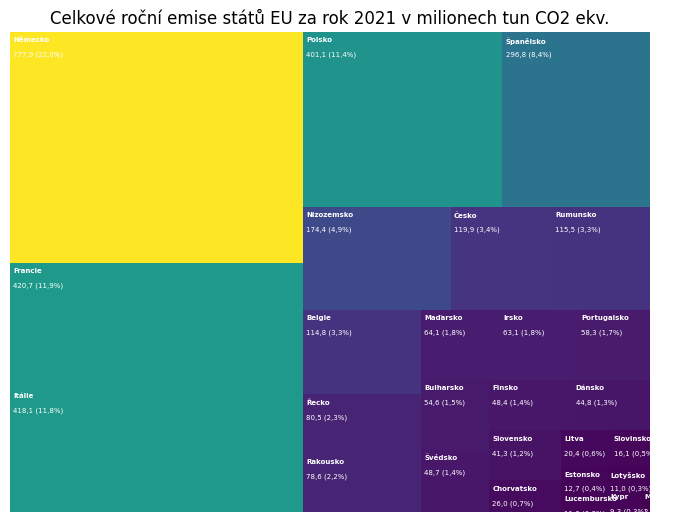

<Figure size 640x480 with 0 Axes>

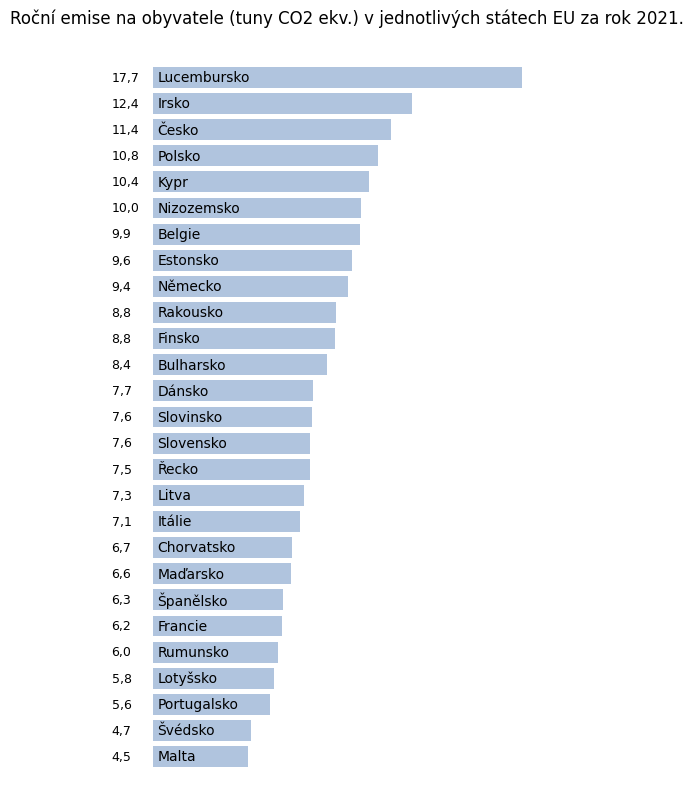

In [14]:
# draw plots
_draw_treemap_plot(YEAR, df)
_draw_barh_plot(YEAR, df)

## Generate accompanying text for the web

First, helper functions making use of the dataset are defined.

In [8]:
def _get_population_in_mio(geo: Geo, decimals: int = 1) -> str:
    return czech_float(df.loc[geo.value, "population"] / 1_000_000, decimals=decimals)


def _get_emissions(geo: Geo) -> str:
    return czech_float(df.loc[geo.value, "emissions"])


def _get_order(geo: Geo) -> str:
    return df.loc[geo.value, "order"]


def _get_top_list() -> str:
    output = ""
    for index, row in df.head(4).iterrows():
        output += f"""
* {row["country"]} se svými cca {czech_float(row["population"] / 1_000_000, 0)} mil. obyvateli: {czech_float(row["emissions"])} mil. t CO<sub>2</sub>eq"""
    return output


#### Fact check statements from the text

Update the statements if they are no more correct!

In [9]:
print(f"""
Is population of Czechia similar as population of Sweden?
- CZ: {_get_population_in_mio(Geo.CZ)} M
- SE: {_get_population_in_mio(Geo.SE)} M""")

print(f"""
Are emissions per capita of Czechia still more than 2x of emissions per capita of Sweden?
- CZ: {df.loc[Geo.CZ.value, "em_per_capita"].round(2)} t
- SE: {df.loc[Geo.SE.value, "em_per_capita"].round(2)} t
- SEx2: {df.loc[Geo.SE.value, "em_per_capita"].round(2) * 2} t""")

print(f"""
Are the top emitters per capita still the same?
- 1. LU: real order: {_get_order(Geo.LU)}
- 2. IE: real order: {_get_order(Geo.IE)}
- 3. CZ: real order: {_get_order(Geo.CZ)}""")



Is population of Czechia similar as population of Sweden?
- CZ: 10,5 M
- SE: 10,4 M

Are emissions per capita of Czechia still more than 2x of emissions per capita of Sweden?
- CZ: 11.42 t
- SE: 4.69 t
- SEx2: 9.38 t

Are the top emitters per capita still the same?
- 1. LU: real order: 1
- 2. IE: real order: 2
- 3. CZ: real order: 3


In [10]:
accompanying_text = f'''---
layout:     infographic
title:      "Emise skleníkových plynů států EU"
slug:       "emise-eu"
redirect_from: "/emise-eu"
published:  2019-08-22
weight:     95
tags-scopes: [ eu ]
tags-topics: [ emise ]
caption:    "Poměrové srovnání ročních emisí 27 členských států EU a přepočet na obyvatele."
data-orig:  [["Náš Jupyter notebook", "https://github.com/faktaoklimatu/data-analysis/blob/master/notebooks/emissions/treemap-EU.ipynb"]]
---

## Jak číst tento graf?

{get_gases_info()}

{{% include preview-box.html
    title="Jak jsou emise rozdělené mezi světové regiony?"
    text="Obdobnou infografiku jsme vytvořili i pro celosvětové emise skleníkových plynů."
    slug="emise-svet"
%}}

V levé části jsou celkové roční emise členských států EU za rok {YEAR} v mil. tun CO<sub>2</sub>eq, vč. procentuálního zastoupení. Plocha zabraná konkrétním státem odpovídá poměru vůči celku.

Největší státy EU (jak [z hlediska počtu obyvatel](https://en.wikipedia.org/wiki/List_of_European_Union_member_states_by_population), tak [z hlediska HDP](https://en.wikipedia.org/wiki/List_of_sovereign_states_in_Europe_by_GDP_(nominal))) mají v absolutních číslech nejvyšší emise:
{_get_top_list()}

Česká republika jako stát s cca {_get_population_in_mio(Geo.CZ)} mil. obyvateli a emisemi {_get_emissions(Geo.CZ)} mil. t CO<sub>2</sub>eq __je v přepočtu na obyvatele {_get_order(Geo.CZ)}. největším emitentem EU__ a má více než 2× vyšší emise než stejně velké Švédsko (cca {_get_population_in_mio(Geo.SE)} mil. obyvatel).

## Zajímavosti a komentáře k ročním emisím na obyvatele

* Lucembursko, které je v přepočtu na obyvatele na prvním místě, má [dle platformy Votum Klima](https://today.rtl.lu/news/luxembourg/a/1184731.html) tak vysoké emise kvůli nafto-benzínovému turismu (5× vyšší než průměr EU)
* Irsko, na druhém místě, má velmi vysoký podíl zemědělské produkce (skoro 5× vyšší než průměr EU)
* Česko, na třetím místě, má velmi vysoký podíl špinavé energetiky (2× vyšší než průměr EU, zejména vlivem hnědouhelných elektráren) - viz naše  [související infografika](/infografiky/emise-cr-detail).

## Poznámky k datům o emisích

{get_methodology_info()}

{get_trade_and_flights_info(None)}
'''
print(accompanying_text)


---
layout:     infographic
title:      "Emise skleníkových plynů států EU"
slug:       "emise-eu"
redirect_from: "/emise-eu"
published:  2019-08-22
weight:     95
tags-scopes: [ eu ]
tags-topics: [ emise ]
caption:    "Poměrové srovnání ročních emisí 27 členských států EU a přepočet na obyvatele."
data-orig:  [["Náš Jupyter notebook", "https://github.com/faktaoklimatu/data-analysis/blob/master/notebooks/emissions/treemap-EU.ipynb"]]
---

## Jak číst tento graf?

Všechny hodnoty v grafu jsou <glossary id="antropogennisklenikoveplyny">antropogenní emise</glossary> skleníkových plynů CO<sub>2</sub>, N<sub>2</sub>O, CH<sub>4</sub>, HFC, PFC, SF<sub>6</sub>, NF<sub>3</sub> vyjádřené jako <glossary id="co2eq">CO<sub>2</sub>eq</glossary>. Jednotka CO<sub>2</sub> ekvivalent zohledňuje dlouhodobý efekt skleníkových plynů v atmosféře a převádí je na množství CO<sub>2</sub>, které by mělo stejný efekt. Více viz článek [Global warming potential](https://en.wikipedia.org/wiki/Global_warming_potent